# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [210]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *

In [2]:
%matplotlib notebook

## Control Runs Here

In [27]:
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'ang_saxs' 
scat_geometry = 'gi_waxs' 
#scat_geometry = 'gi_saxs'


roi_auto = True #False #True #if True, will automatically create a roi based on the roi_type ( iso/aniso etc), currently only works for SAXS


analysis_type_auto = True #if True, will take "analysis type" option from data acquisition func series
qphi_analysis =  False  #if True, will do q-phi (anisotropic analysis for transmission saxs)

isotropic_Q_mask = 'normal' #'wide' # 'normal' # 'wide'  ## select wich Q-mask to use for rings: 'normal' or 'wide'
phi_Q_mask = 'phi_4x_20deg'   ## select wich Q-mask to use for phi analysis
q_mask_name = ''

force_compress = False #True   #force to compress data 
bin_frame = False   #generally make bin_frame as False
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall =  False #True   #run waterfall analysis
run_profile_plot = False  #run prolfile plot for gi-saxs
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_get_mass_center = False  # Analysis for mass center of reflective beam center
run_invariant_analysis = False
run_one_time =  True  #run  one-time
cal_g2_error =  False  #True  #calculate g2 signal to noise
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time =   True    #run  two-time
run_four_time = False #True #True #False   #run  four-time
run_xsvs=  False #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 3 #the intested single qth             
use_sqnorm = True    #if True, use sq to normalize intensity
use_SG = True #False #True # False        #if True, use the Sawitzky-Golay filter of the avg_img for normalization
use_SG_bin_frames =  False   #if True, use the Sawitzky-Golay filter of the (binned) frame for normalization 

use_imgsum_norm= True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_%s'%get_today_date()     #for pdf report name
run_dose = True # False #True # True #False  #run dose_depend analysis


if scat_geometry == 'gi_saxs':run_xsvs= False;use_sqnorm=False
if scat_geometry == 'gi_waxs':use_sqnorm = False
if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry;roi_auto = False  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False

In [28]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [29]:
CYCLE= '2019_2'  #change clycle here
path = '/XF11ID/analysis/%s/masks/'%CYCLE


username =  getpass.getuser()
username = 'commissioning'
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_2/commissioning/Results/
/XF11ID/analysis/2019_2/commissioning/Results/


## Load Metadata & Image Data



### Load data by giving starting and ending time

In [30]:
#start_time, stop_time = '2017-6-16  0:0:00', '2017-6-16 14:30:00'   #for all June data
#fuids, uids, sids   = get_print_uids( start_time, stop_time)

### Change this line to give a uid

In [31]:

uid=  '17ff526f' #120C 1V 25min(scan num: 10985) (Measurement: sin,10mHz,1V peak to peak, 25min XPCS, 120C18PTO2STO3PTO1SRO J0124171 )

uidstr = 'uid=%s'%uid
print(uidstr)

uid=17ff526f


In [32]:
db[uid].fields()

{'eiger1m_single_image',
 'eiger1m_single_stats1_total',
 'eiger1m_single_stats2_total',
 'eiger1m_single_stats3_total',
 'eiger1m_single_stats4_total',
 'eiger1m_single_stats5_total'}

In [33]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_2/commissioning/Results/17ff526f/


In [34]:
sud = get_sid_filenames(db[uid])
for pa in sud[2]:
    if 'master.h5' in pa:
        data_fullpath = pa
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], data_fullpath ))

scan_id, full-uid, data path are:  10985--17ff526f-c2d1-49c6-810a-a64c0592f2c4--/nsls2/xf11id1/data/2019/05/09/21c5df78-d7c7-4aeb-88d4_404_master.h5


## Load metadata and data

In [35]:
md = get_meta_data( uid )
md_blue = md.copy()


In [36]:
detectors = sorted(get_detectors(db[uid]))
print('The detectors are:%s'%detectors)
if len(detectors) >1:
    md['detector'] = detectors[1]
    print( md['detector'])

The detectors are:['eiger1m_single_image']


In [37]:
if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    reverse= True
    rot90= False
elif md['detector'] =='eiger500K_single_image':    
    reverse= True
    rot90=True
elif md['detector'] =='eiger1m_single_image':    
    reverse= True
    rot90=False
print('Image reverse: %s\nImage rotate 90: %s'%(reverse, rot90))    

Image reverse: True
Image rotate 90: False


In [38]:
try:
    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
    print(cx,cy)
except:
    print('Will find cx,cy later.')

563.0 883.0


### Load ROI defined by "XPCS_Setup" Pipeline

In [39]:
if analysis_type_auto:#if True, will take "analysis type" option from data acquisition func series
    try:
        if scat_geometry != 'gi_saxs':
            qphi_analysis_ = md['analysis'] #if True, will do q-phi (anisotropic analysis for transmission saxs)
            print(md['analysis'])
            if qphi_analysis_ == 'iso':
                qphi_analysis = False
            elif qphi_analysis_ == '':
                qphi_analysis = False
            else:
                qphi_analysis = True
            #for other analysis type, in case of GiSAXS, low_angle/high_anlge for instance    
        else:
            gisaxs_inc_type = md['analysis'] 
        
    except:
        gisaxs_inc_type = None
        print('There is no analysis in metadata.')
        
print('Will %s qphis analysis.'%['NOT DO','DO'][qphi_analysis]) 

if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False     
    
print(scat_geometry_)    


Will NOT DO qphis analysis.
gi_waxs


In [41]:
imgs = load_data( uid, md['detector'], reverse= reverse, rot90=rot90  )
md.update( imgs.md );Nimg = len(imgs);
#md['beam_center_x'], md['beam_center_y']  = cx, cy
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

#md['acquire period' ] = md['cam_acquire_period']
#md['exposure time'] =  md['cam_acquire_time']
mdn = md.copy()


The data are: Pipeline processed through proc_func. Original repr:
    EigerImages processed through proc_func. Original repr:
        <Frames>
        Length: 1500 frames
        Frame Shape: 1065 x 1030
        Pixel Datatype: uint32


In [45]:
## This should work for dscan with each motor position having one frame
#imgs = load_data( uid, 'eiger4m_single_image') 
#md = imgs.md
#pixel_mask = imgs.md['binary_mask']

In [46]:
#imgs = pims.pipeline(lambda img: np.average(img,axis=0))(imgs)
#imgs

In [54]:
#plt.figure();plt.imshow(imgs[10],vmax=100)

# Don't Change these lines below here

* get data

In [48]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> 17ff526f
number of images--> 1500
uid--> 17ff526f-c2d1-49c6-810a-a64c0592f2c4
scan_id--> 10985
start_time--> 2019-05-09 23:17:29
stop_time--> 2019-05-09 23:42:31
sample--> 18PTO2STO3PTO1SRO J0124171
Measurement--> sin,10mHz,1V peak to peak, 25min XPCS, 120C18PTO2STO3PTO1SRO J0124171
acquire period--> 1
exposure time--> 1
det_distance--> 1.495
beam_center_x--> 563.0
beam_center_y--> 883.0


## Overwrite Some Metadata if Wrong Input

In [49]:
center = [md['beam_center_x'],md['beam_center_y']]
inc_x0 =  center[1]
inc_y0=   center[0]
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

Beam_center_x has been changed to 563.0. (no change in raw metadata): 
Beam_center_y has been changed to 883.0.  (no change in raw metadata): 
uid--> uid=17ff526f
dpix--> 0.07500000356230885
Ldet--> 1495.0
lambda_--> 1.2874786853790283
exposuretime--> 0.999997
timeperframe--> 1.0
center--> [883, 563]
path--> /XF11ID/analysis/2019_2/commissioning/Results/17ff526f/


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the blow line to give mask filename

In [50]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
    BadPix =     np.load('/XF11ID/analysis/2018_1/BadPix_4M.npy'  )  
    Chip_Mask.ravel()[BadPix] = 0
elif md['detector'] =='eiger500K_single_image':
    #print('here')
    Chip_Mask=  np.load( '/XF11ID/analysis/2017_1/masks/Eiger500K_Chip_Mask.npy')  #to be defined the chip mask
    Chip_Mask = np.rot90(Chip_Mask)
    pixel_mask = np.rot90(  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool))   )
    
else:
    Chip_Mask = 1
print(Chip_Mask.shape, pixel_mask.shape)

(1065, 1030) (1065, 1030)


In [51]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2019_2/masks/'    
    mask_name =  'Mar28_2019_4M_GISAXS.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2019_2/masks/'
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
        mask_name = 'May15_2019_4M_SAXS.npy'     
    elif md['detector'] =='eiger500K_single_image':    
        mask_name = 'May15_2019_500K_SAXS.npy'    
        
elif scat_geometry == 'gi_waxs':    
    mask_path = '/XF11ID/analysis/2019_2/masks/'    
    mask_name =  'May7_2019_1M_WAXS.npy'  

<IPython.core.display.Javascript object>


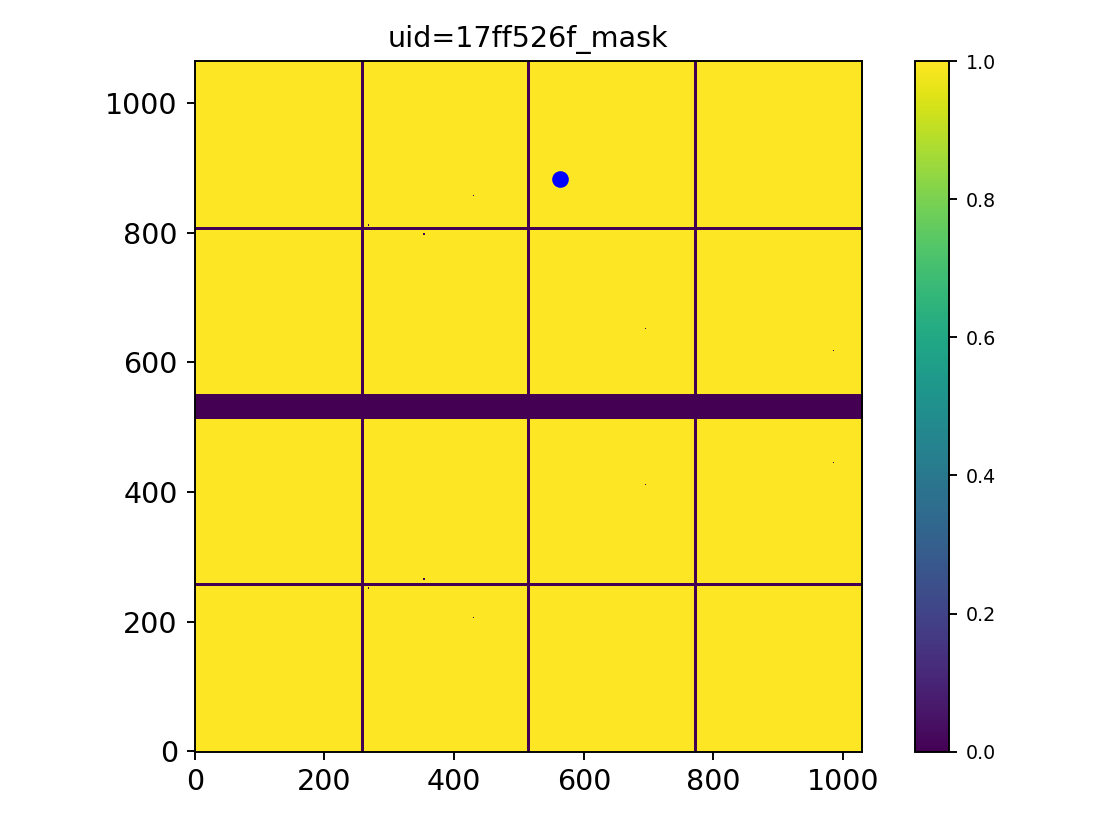

In [52]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= reverse, rot90=rot90  ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1, center=center[::-1])
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

In [31]:
data_dir

'/XF11ID/analysis/2019_1/yuzhang/Results/4e642b/'

<IPython.core.display.Javascript object>


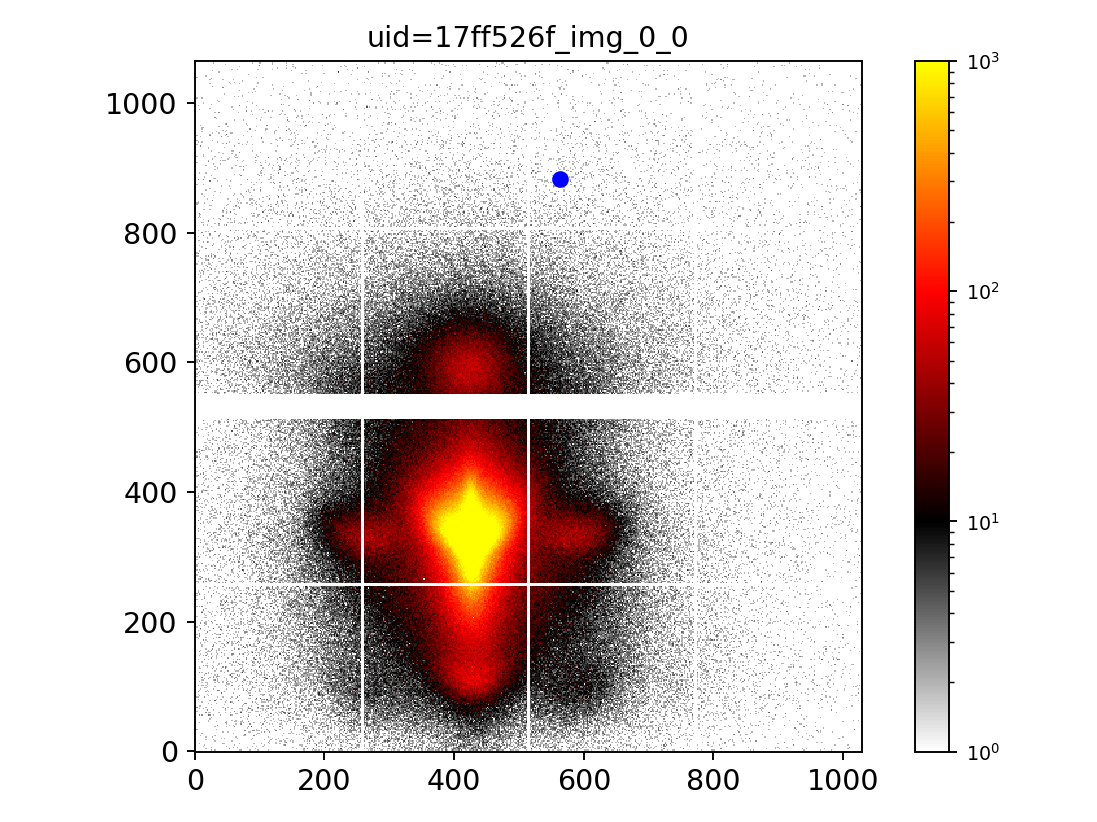

In [56]:
show_img(imgsa[0],  vmin= 1, vmax= 1e3, logs=True, aspect=1, 
         image_name= uidstr + '_img_0_0',  save=True, path=data_dir,  cmap = cmap_albula, center=center[::-1] )


In [57]:
setup_pargs

{'uid': 'uid=17ff526f',
 'dpix': 0.07500000356230885,
 'Ldet': 1495.0,
 'lambda_': 1.2874786853790283,
 'exposuretime': 0.999997,
 'timeperframe': 1.0,
 'center': [883, 563],
 'path': '/XF11ID/analysis/2019_2/commissioning/Results/17ff526f/'}

## Load ROI

In [60]:
##For SAXS 
roi_path = '/XF11ID/analysis/2019_2/masks/'
roi_date = 'May15'

if scat_geometry =='saxs':
    ## For auto load roi mask
    if roi_auto: 
        general_path = '/nsls2/xf11id1/analysis/2017_1/masks/'
        roi_mask_norm = general_path + 'general_roi_mask_norm.npy' 
        roi_mask_wide = general_path + 'general_roi_mask_wide.npy' 
        roi_mask_phi_4x_20deg = general_path + 'general_roi_mask_phi_4x_20deg.npy' 
        roi_mask_12x_30deg = general_path + 'general_roi_mask_12x_30deg.npy' 
        roi_mask_12x_15deg_flow = general_path + 'general_roi_mask_12x_15deg_flow.npy'
        if qphi_analysis ==  False:
            if isotropic_Q_mask == 'normal':
                fp = roi_mask_norm
            elif isotropic_Q_mask == 'wide':
                fp = roi_mask_wide
        elif qphi_analysis:
            if phi_Q_mask == 'phi_4x_20deg':
                fp = roi_mask_phi_4x_20deg
            elif phi_Q_mask == 'phi_12x_30deg': 
                fp = roi_mask_phi_12x_30deg
            elif phi_Q_mask == 'phi_12x_15deg_flow': 
                fp = roi_mask_phi_12x_15deg_flow 
        roi_mask0 = np.load(fp)    
        old_cen=[4000,4000]        
        roi_mask, qval_dict, qwid_dict = get_roi_mask_qval_qwid_by_shift( 
                        new_cen=center, new_mask= mask, old_cen=old_cen,
                                    old_roi_mask=roi_mask0, limit_qnum= None,
                                    setup_pargs= setup_pargs,  geometry = scat_geometry_,
                                    ) 
 
    else: 
        if qphi_analysis ==  False:
            if isotropic_Q_mask == 'normal':
                #print('Here')
                q_mask_name='rings'
                if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                    fp = roi_path + 'roi_mask_%s_4M_norm.pkl'%roi_date                 

                elif md['detector'] =='eiger500K_single_image': #for 500K   
                    fp = roi_path + 'roi_mask_%s_500K_norm.pkl'%roi_date   


            elif isotropic_Q_mask == 'wide':
                q_mask_name='wide_rings'
                if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M   
                    fp = roi_path + 'roi_mask_%s_4M_wide.pkl'%roi_date   
                elif md['detector'] =='eiger500K_single_image': #for 500K   
                    fp = roi_path + 'roi_mask_%s_500K_wide.pkl'%roi_date   


        elif qphi_analysis:
            if phi_Q_mask =='phi_4x_20deg':
                q_mask_name='phi_4x_20deg'
                if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                    fp = roi_path + 'roi_mask_%s_4M_phi_4x_20deg.pkl'%roi_date   
                elif md['detector'] =='eiger500K_single_image': #for 500K 
                    fp = roi_path + 'roi_mask_%s_500K_phi_4x_20deg.pkl'%roi_date   


        #fp = 'XXXXXXX.pkl'            
        roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
        #print(fp)

## Gi_SAXS 
elif scat_geometry =='gi_saxs':    
    # static mask    
    ss = '4f48c2c9'
    ss = '9910469a'
    fp = '/XF11ID/analysis/2019_1/masks/uid=%s_roi_masks.pkl'%ss
    roi_masks,qval_dicts = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data    
    print('The static mask is: %s.'%fp)    

    fp = '/XF11ID/analysis/2019_1/masks/uid=%s_roi_mask.pkl'%(ss)
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    print('The dynamic mask is: %s.'%fp)
    # q-map
    fp = '/XF11ID/analysis/2019_1/masks/uid=%s_qmap.pkl'%(ss)
    #print(fp)
    qr_map, qz_map, ticks, Qrs, Qzs,  Qr, Qz, inc_x0,refl_x0, refl_y0 = cpk.load( open(fp, 'rb' )  )
    print('The qmap is: %s.'%fp)
    
## WAXS 
elif scat_geometry =='gi_waxs': 
    #fp = '/XF11ID/analysis/2019_1/masks/uid=ca2ccb14_roi_mask_5PTO_130C_PTO.pkl'     
    fp =  '/XF11ID/analysis/2019_2/masks/uid=17ff526f_roi_mask_Hybrid_120C.pkl'
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data

print(roi_mask.shape)    


(1065, 1030)


<IPython.core.display.Javascript object>


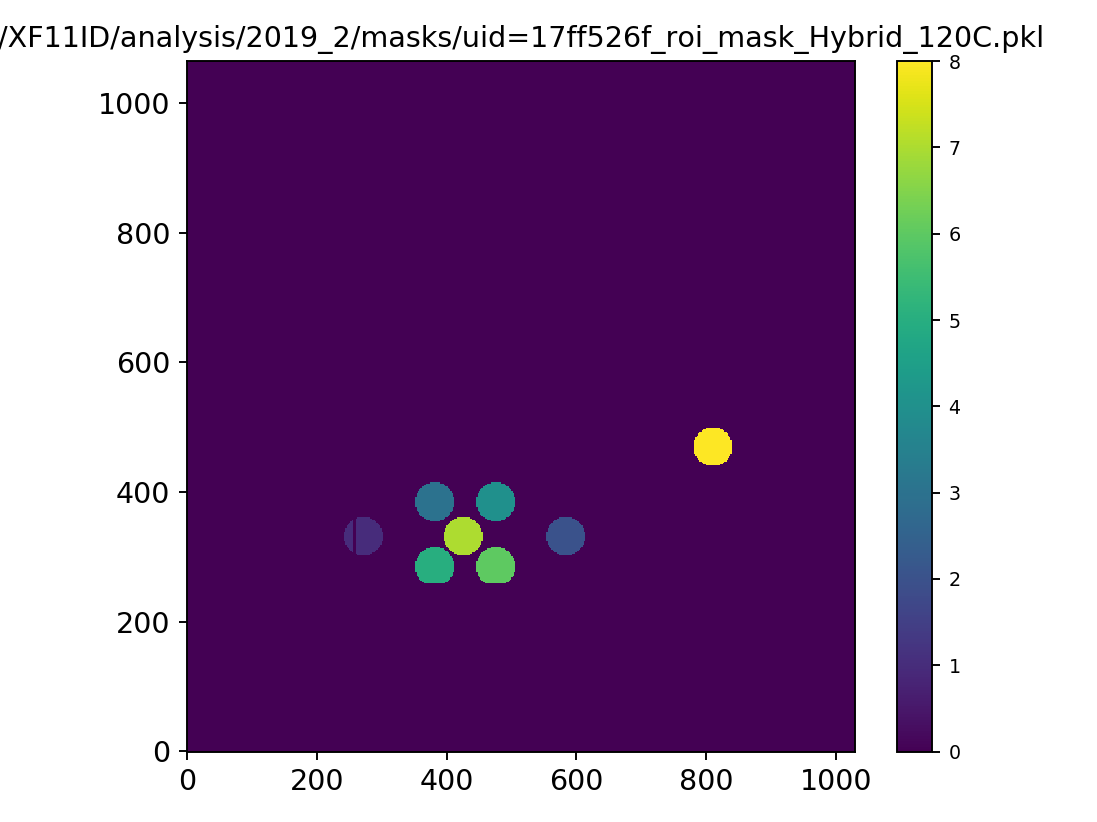

In [61]:
show_img(roi_mask, aspect=1.0, image_name = fp)#, center=center[::-1])

In [84]:
bind = roi_mask
qind, pixelist = roi.extract_label_indices(roi_mask)
qind = np.array(qind)
noqs = len(np.unique(qind))
print(noqs)
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
print(nopr)

8
[2599 2809 2809 2809 2746 2746 2809 2809]


In [80]:
#bind

## Cross correlation

In [150]:
from skbeam.core.roi import segmented_rings, ring_edges
from skbeam.core.utils import radial_grid, angle_grid
from pyCHX.chx_crosscor import CrossCorrelator2, CrossCorrelator1
from pyCHX.chx_Fitters2D import Gauss2DFitter

### Check roi-mask

In [147]:
binsizes=np.bincount(bind.ravel())
threshold = 800
bad_qind=np.where( binsizes < threshold )[0]
#bad_qind=np.arange(81,86)#split by mask
print(bad_qind)
for w in bad_qind :
    print(w)
    bind[ np.where( bind== w )] =0
#binsizes=binsizes[np.flatnonzero(binsizes)]

[]


In [148]:
avg_img  = imgsa[0]

<IPython.core.display.Javascript object>


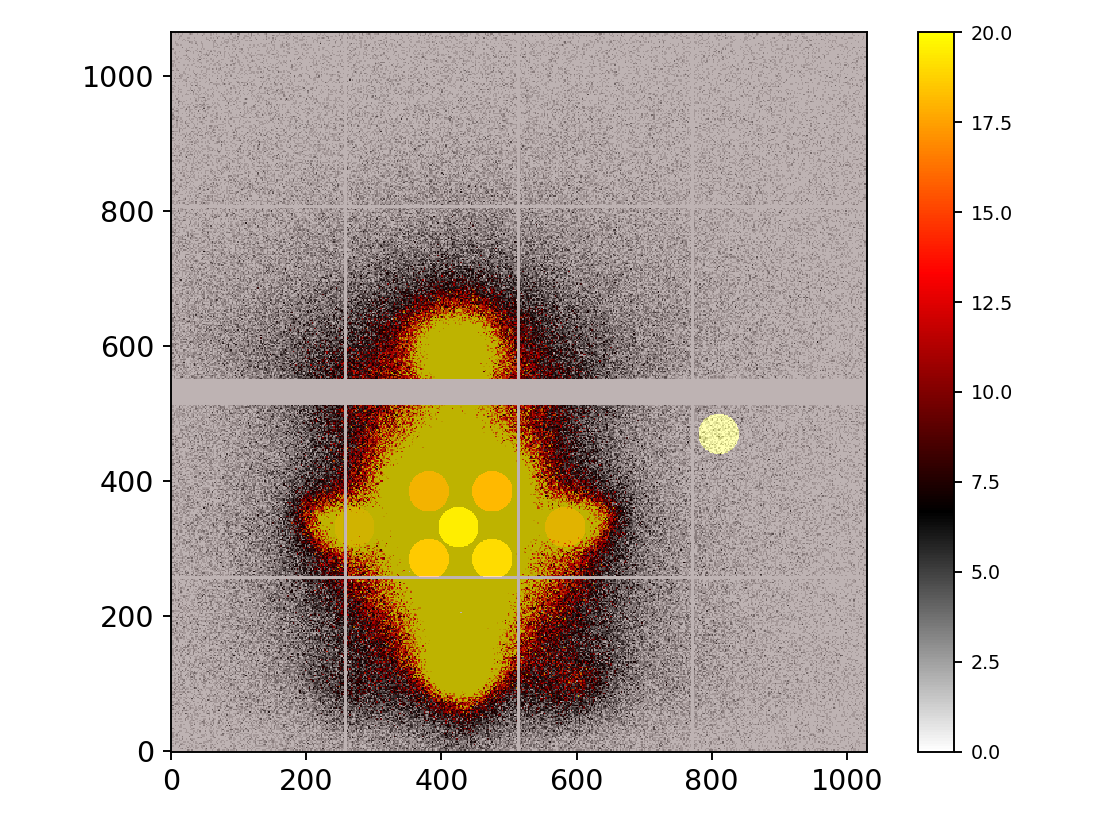

In [149]:
show_img(imgsa[0], label_array=(1+.1*bind), alpha=0.3, vmax=20,aspect=1,  cmap=cmap_albula)

<IPython.core.display.Javascript object>


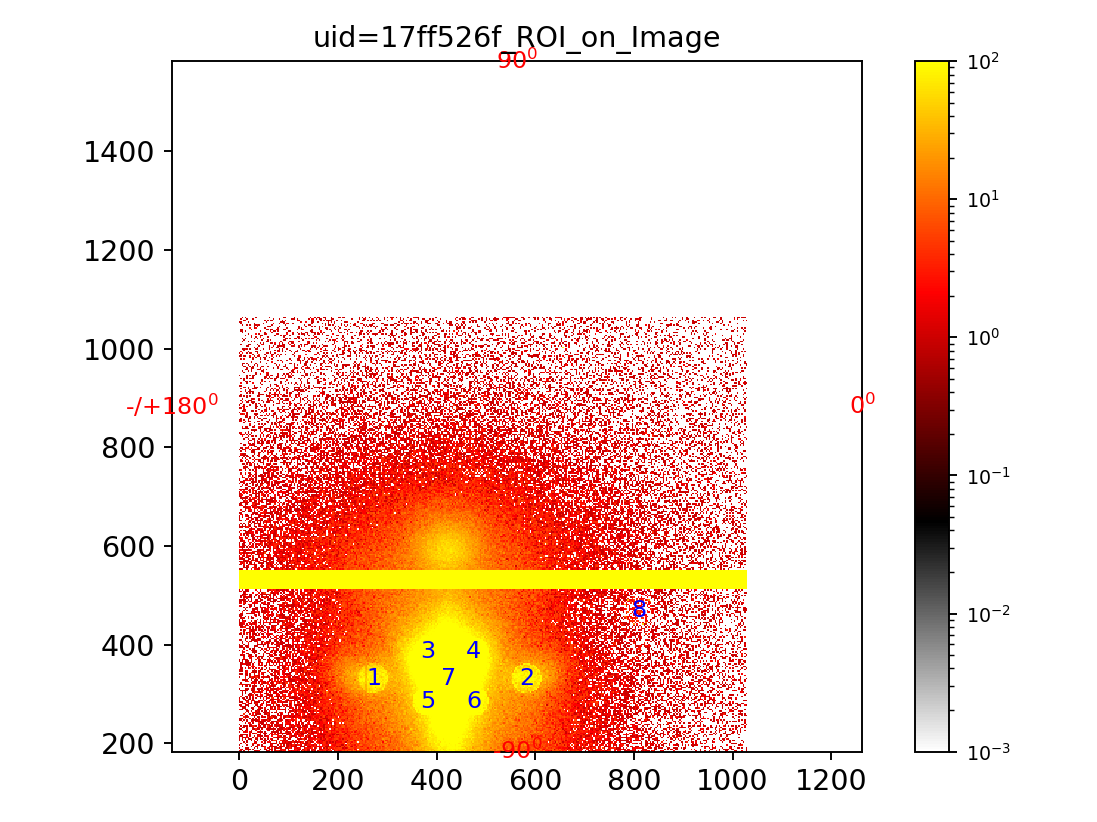

In [93]:
show_ROI_on_image( imgs[0] , bind, center, label_on = True, rwidth = 700, alpha=.9,  
         save=True, path=data_dir, uid=uidstr, vmin= 1e-3,
         vmax= 100, #np.max(avg_img),
         aspect=1,
         show_roi_edge=True,     
         show_ang_cor = True) 

In [176]:
ccorr_sym = CrossCorrelator1(mask.shape, 
                mask=bind*mask, normalization='symavg')

In [177]:
def extract_param(bestfits, key):
    Nframes = len(bestfits)
    params = np.zeros(Nframes)
    for i in range(Nframes):
        params[i] = bestfits[i][key]
    return params

def plarrows(xs,ys,dxs,dys,**kwargs):
    for i in range(len(xs)):
        plt.arrow(xs[i],ys[i],dxs[i],dys[i],**kwargs)



## Normalization

In [216]:
use_SG = True

In [217]:
cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'   
bin_frame_number=1
if bin_frame_number==1:   
    cmp_file = '/uid_%s.cmp'%md['uid']
else:
    cmp_file = '/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number)
    
filename = cmp_path + cmp_file
mask2, avg_img, imgsum, bad_frame_list_ =  cpk.load( open(filename + '.pkl', 'rb' ) )

In [219]:
if use_sqnorm:#for transmision SAXS
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
    print('Using circular average in the normalization of CC for SAXS scattering.')
elif use_SG:#for Gi-SAXS or WAXS
    avg_imgf = sgolay2d( avg_img, window_size= 11, order= 5) * mask
    norm=np.ravel(avg_imgf)[pixelist]    
    print('Using smoothed image by SavitzkyGolay filter in the normalization of CC.')      
elif use_SG_bin_frames:#for Gi-SAXS or WAXS
    avg_imgf = sgolay2d( avg_img, window_size= 11, order= 5) * mask
    norm_avg=np.ravel(avg_imgf)[pixelist]    
    #print('Using smoothed image by SavitzkyGolay filter in the normalization of G2.')
    bins_number = 4 
    norm = get_SG_norm( FD, pixelist, bins=bins_number, mask=mask, window_size= 11, order=5 )   
    print('Using smoothed bined: %s frames  by SavitzkyGolay filter in the normalization of CC.'%bins_number)     
else:     
    norm= None
    print('Using simple (average) normalization of CC.')      

if use_imgsum_norm:
    imgsum_ = imgsum
    print('Using frame total intensity for intensity normalization in CC calculation.')      
else:
    imgsum_ = None    
import time

Using smoothed image by SavitzkyGolay filter in the normalization of CC.
Using frame total intensity for intensity normalization in CC calculation.


## Do croess cor for two images

In [258]:
no1=200  #the no1 th image
no2= 230  # no2 th image
img1 = imgsa[no1]/(avg_imgf*imgsum[no1])  
img2 = imgsa[no2]/( avg_imgf*imgsum[no2] )
cc = ccorr_sym( img1,img2 )
#cc = ccorr_sym( imgs[no1] ) #autocorrelation

cc: 100%|██████████| 8/8 [00:00<00:00, 238.22it/s]


## check one roi cross-cor results

<IPython.core.display.Javascript object>


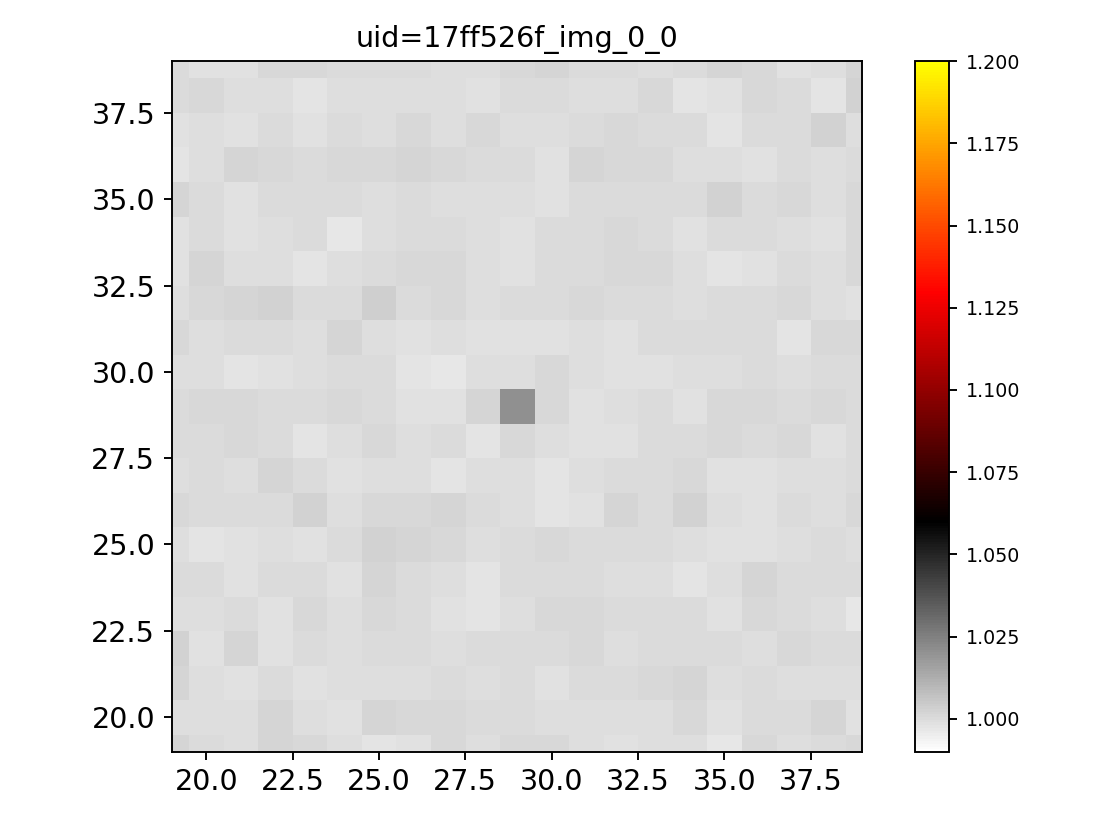

In [259]:
id=1
w=10
cens=ccorr_sym.centers[id]
show_img(  cc[id] ,  vmin=.99, vmax= 1.2, logs= False, aspect=1, 
         xlim=[cens[1]-w,cens[1]+w],ylim=[cens[0]-w,cens[0]+w],
         image_name= uidstr + '_img_0_0',  save=True, path=data_dir,  cmap = cmap_albula ) 

In [262]:
w= 10
fitlist = list()
Nres = len(cc)
for k in tqdm(range(Nres)):
    #print("iteration {},{}".format(k,Nres))
    cens=ccorr_sym.centers[k]
    region=cc[k][cens[0]-w:cens[0]+w,cens[1]-w:cens[1]+w]
    gfit = Gauss2DFitter()
    best_values_sym = gfit(region)
    fitlist.append(best_values_sym)
#best_fits.append(fitlist)

100%|██████████| 8/8 [00:00<00:00, 41.50it/s]


In [265]:
#fitlist

In [263]:
fitlist[2]

{'baseline': 1.000125338780785,
 'amp': 0.46630471208703006,
 'xc': 8.908349876411197,
 'yc': 10.403426376420793,
 'sigmax': 0.004278869873624825,
 'sigmay': 0.5365996479903722,
 'chisq': 9.061452639791573e-07}

<IPython.core.display.Javascript object>


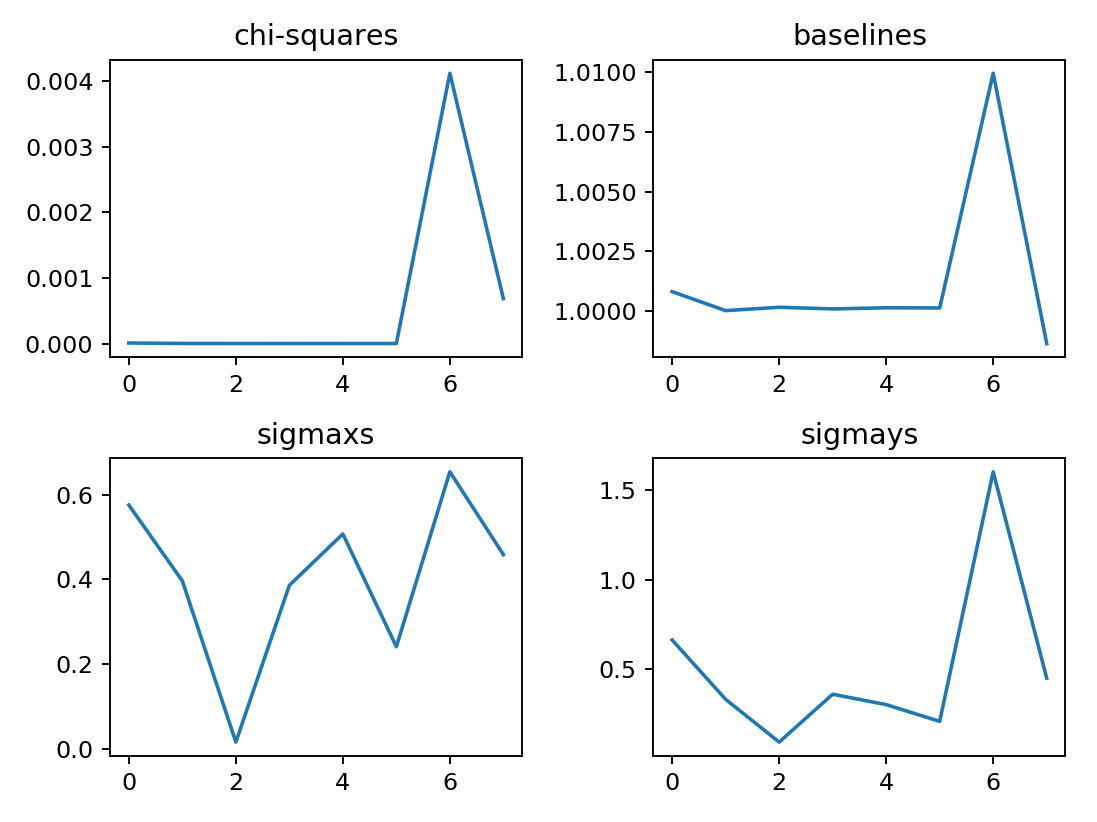

In [261]:
chisqs=extract_param(fitlist,'chisq')
baselines=extract_param(fitlist,'baseline')
sigmaxs=extract_param(fitlist,'sigmax')
sigmays=extract_param(fitlist,'sigmay')
fig,axes=plt.subplots(2,2)
axes[0,0].plot(chisqs)
axes[0,0].set_title("chi-squares")
axes[0,1].plot(baselines)
axes[0,1].set_title("baselines")
axes[1,0].plot(sigmaxs)
axes[1,0].set_title("sigmaxs")
axes[1,1].plot(sigmays)
axes[1,1].set_title("sigmays")
fig.tight_layout()

<IPython.core.display.Javascript object>


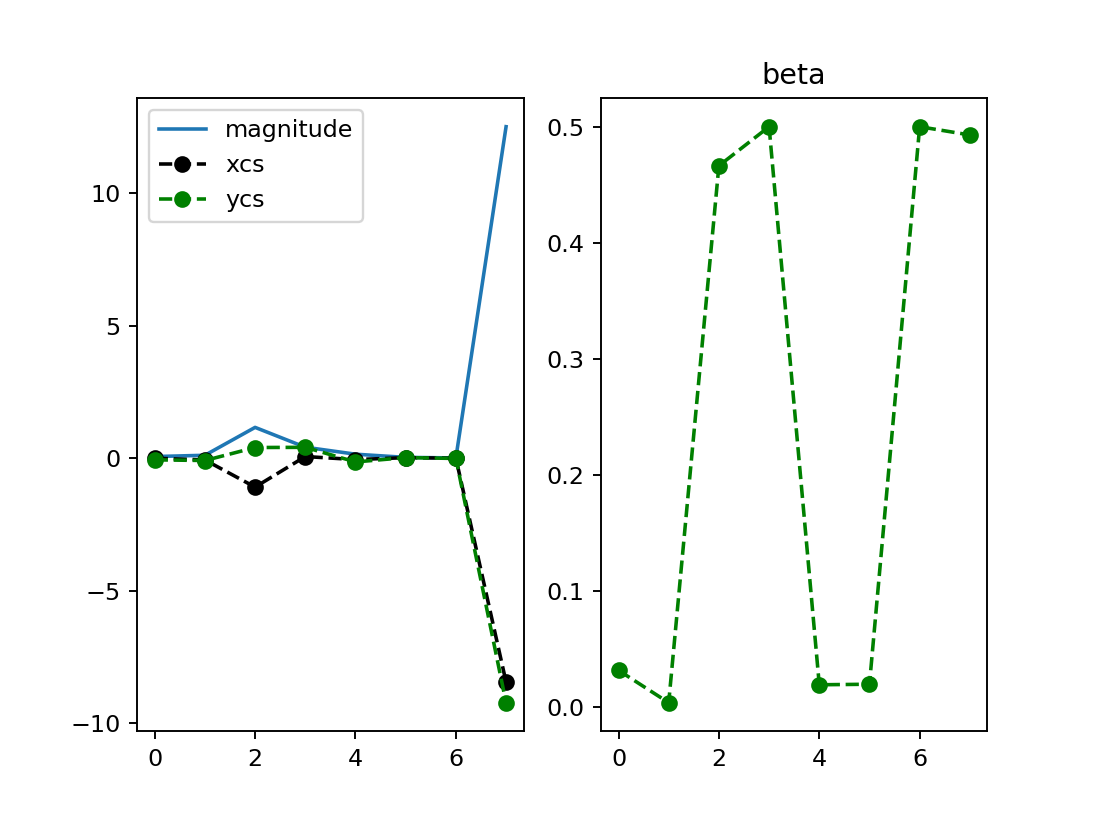

Text(0.5, 1.0, 'beta')

In [237]:
xcs=extract_param(fitlist,'xc')-w
ycs=extract_param(fitlist,'yc')-w
beta=extract_param(fitlist,'amp')
fig,ax=plt.subplots(1,2)
ax[0].plot(np.hypot(xcs,ycs),label="magnitude")
ax[0].plot(xcs,'ko--',label="xcs")
ax[0].plot(ycs,'go--',label="ycs")

#ax[0].set_ylim(-1,1)
ax[0].legend()
ax[1].plot(beta, 'go--')
ax[1].set_title("beta")

In [238]:
chism = chisqs.mean()
chisd = chisqs.std()
sxsm  = sigmaxs.mean()
sxsd  = sigmaxs.std()
sysm  = sigmays.mean()
sysd  = sigmays.std()
bm = beta.mean()
bd = beta.std()

<IPython.core.display.Javascript object>


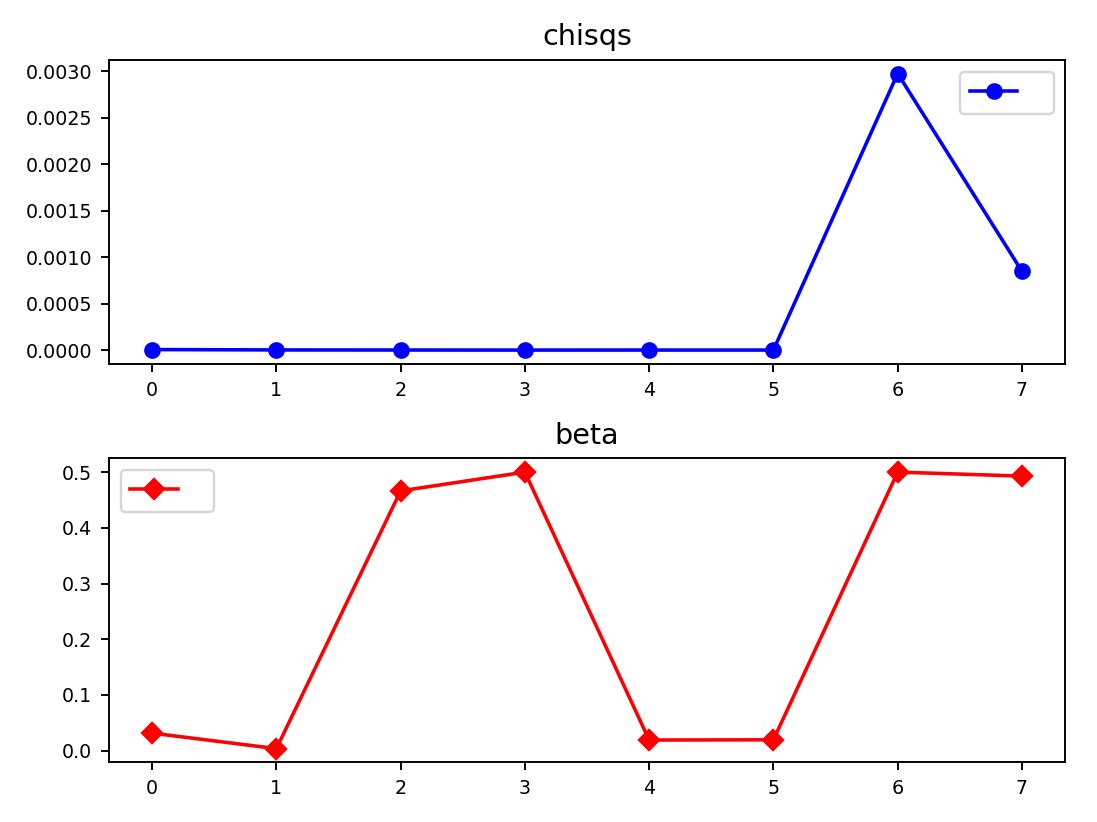

In [239]:
#fig,ax = plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(211)
#plot1D( chisqs, m='o', c='b', ax=ax, title='chisqs')
plot1D( chisqs, m='o', c='b', ax=ax, title='chisqs')
ax = fig.add_subplot(212)
plot1D( beta, m='D', c='r', ax=ax, title='beta')
fig.tight_layout()

In [240]:
#find subregions centers.
img= imgs[no1]
y0,x0 = (md['beam_center_y'], md['beam_center_x'])
Q = radial_grid((y0,x0), img.shape)
PHI = angle_grid((y0, x0), img.shape)
QX, QY = Q*np.cos(PHI), Q*np.sin(PHI)

cnts = np.where(np.diff(ccorr_sym.pos))
qxs = np.bincount(bind.ravel(), weights=QX.ravel())[ccorr_sym.ids]
qxs /= binsizes[ccorr_sym.ids]
qys = np.bincount(bind.ravel(), weights= QY.ravel())[ccorr_sym.ids]
qys /= binsizes[ccorr_sym.ids]

<IPython.core.display.Javascript object>


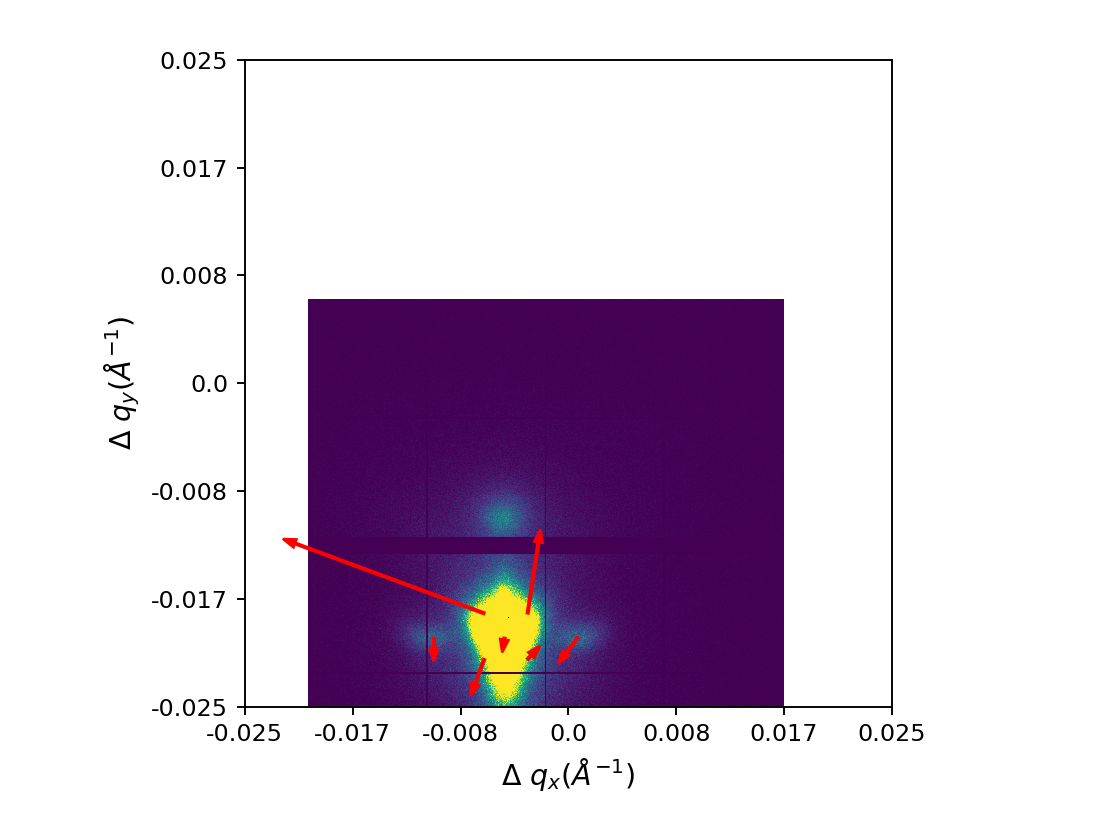

In [241]:
vecmags = np.hypot(xcs,ycs)
w = np.where(vecmags < 2)[0]
scl=150 *2.5
#from plot.plarrows import plarrows
fig,ax=plt.subplots()
#qextent = np.array([QX[0,0], QX[0,-1], QY[-1, 0], QY[0,0]])
wd= 700 #800
#qextent = np.array( [q_saxs[0], q_saxs[wd], q_saxs[0], q_saxs[wd] ])


ax.imshow(imgsa[0],vmin=0,vmax= np.average(imgsa[0]) * 5,
         extent=None,
         )
plarrows(qxs[w]+x0, qys[w]+y0, xcs[w]*scl, ycs[w]*scl, head_width=scl*.05, width=scl*.01,color='red');
#ax.set_title('uid=%s'%uid)
ax.set_title( ' ')
#xlim(-.03, .01);ylim(-.03, .01)

ax.set_xlim(  center[1] -wd, center[1] + wd    )
ax.set_ylim(  center[0] -wd, center[0] + wd    )


ytickp = np.linspace(   center[0] -wd, center[0] + wd , 7    )
ytick =  np.round( np.linspace(-0.0254, 0.02544, 7), 3)
tick = plt.yticks( ytickp, ytick )

xtickp = np.linspace(   center[1] -wd, center[1] + wd ,7    )
xtick =  np.round( np.linspace(-0.0254, 0.02544, 7), 3)
tick = plt.xticks( xtickp, xtick )

kfont =  1
ax.set_xlabel( r'$\Delta\ q_x (\AA^{-1})$', fontsize=12 * kfont )
ax.set_ylabel( r'$\Delta\ q_y (\AA^{-1})$', fontsize=12 * kfont )


fig.savefig( data_dir + 'uid=%s_speckle_shift.png'%uid)
#ax.plot(ycs,label="ycs")
fig.tight_layout()


In [242]:
#plt.figure();plt.imshow(bind);plt.colorbar()

In [187]:
#fig,ax=plt.subplots()
#qmag=np.hypot(qxs[w],qys[w])
#ax.scatter(qmag,vecmags[w])


In [243]:
#plot amplitudes
pos=ccorr_sym.pos
#plot subregion on full  image
im=np.zeros_like(imgs[no2])+0.0
im2=im.copy()
for id in range(ccorr_sym.nids):
    pii=ccorr_sym.pii[pos[id]:pos[id+1]]
    pjj=ccorr_sym.pjj[pos[id]:pos[id+1]]
    im2[pii,pjj]=beta[id]
    im[pii,pjj]=np.sqrt(xcs[id]**2+ycs[id]**2)

In [244]:
print(im2.shape)

(1065, 1030)


<IPython.core.display.Javascript object>


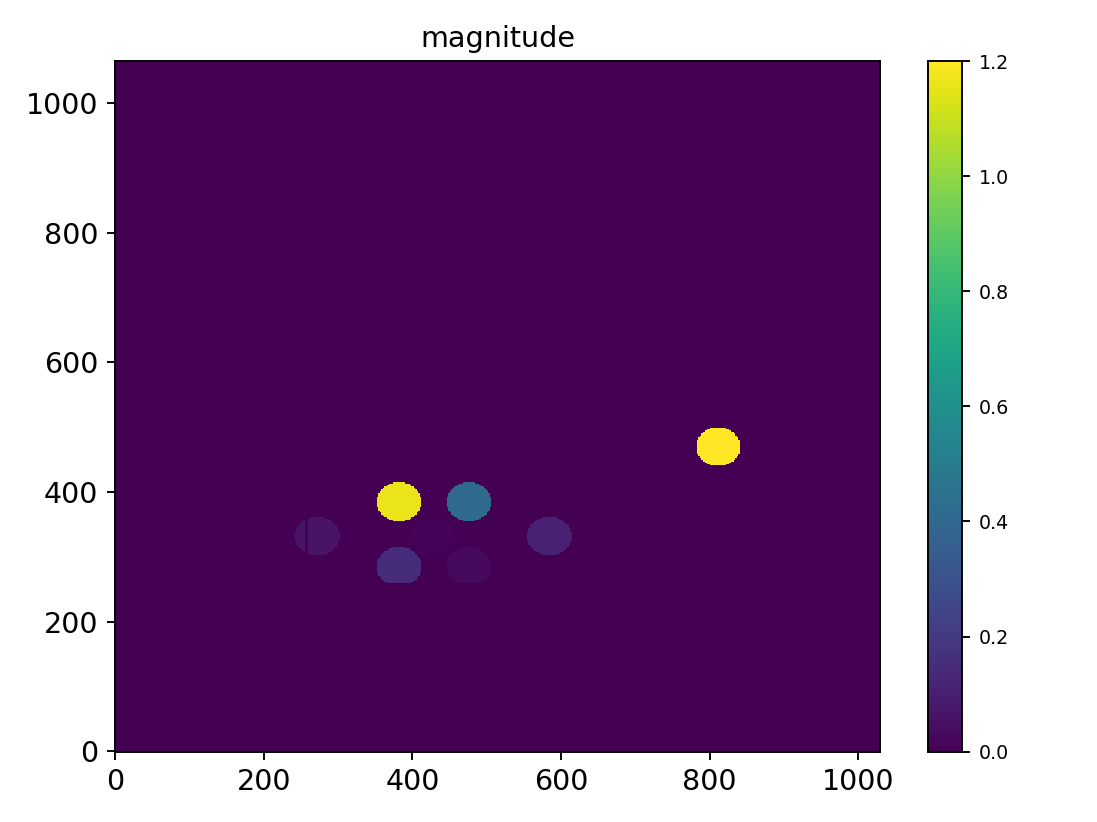

In [245]:
show_img(im,vmax=1.2,vmin=.0,image_name='magnitude')

<IPython.core.display.Javascript object>


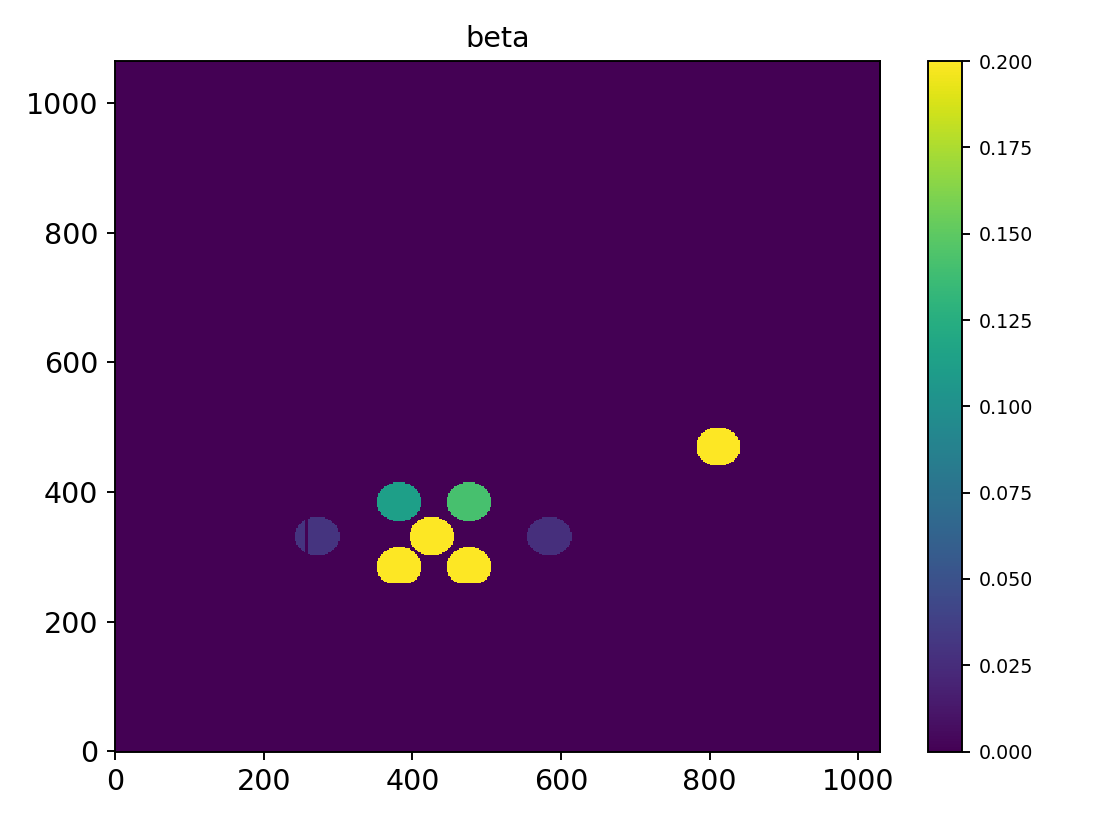

In [191]:
show_img(im2,vmax=.2,vmin=.0,image_name='beta')

<IPython.core.display.Javascript object>


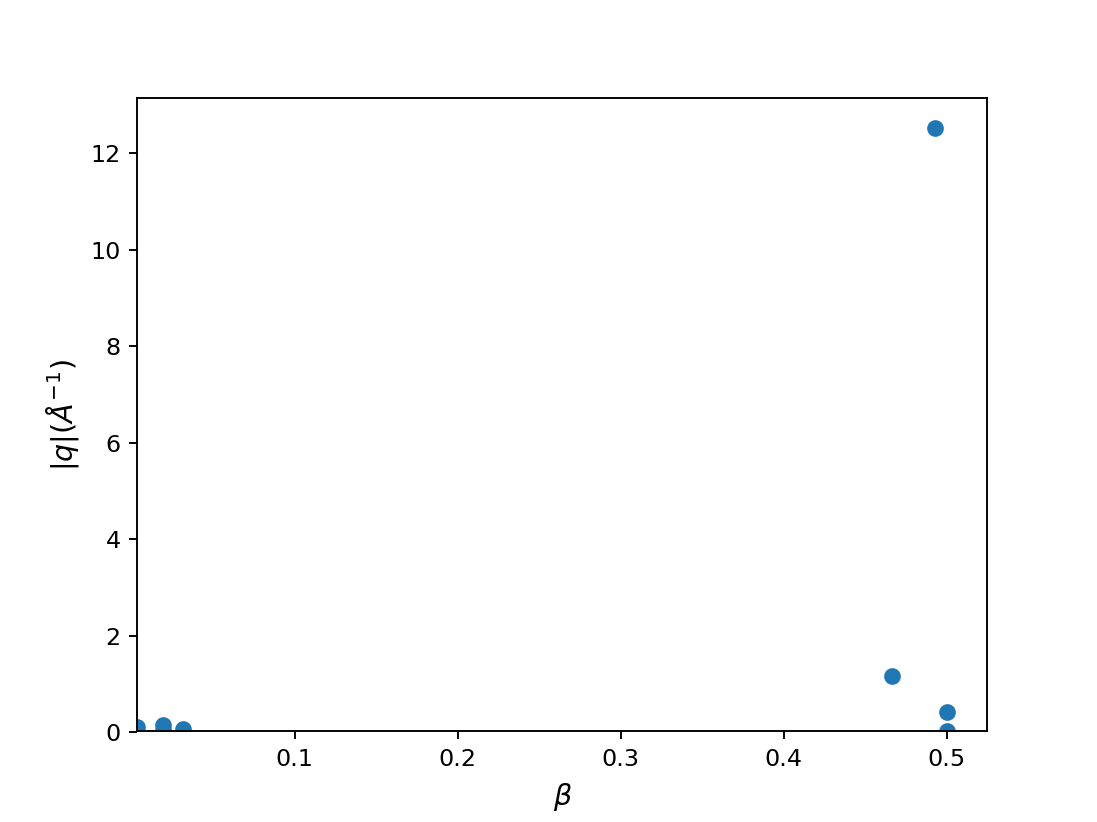

Text(0.5, 0, '$\\beta$')

In [246]:
fig,ax=plt.subplots()
ax.scatter(beta,vecmags)
ax.set_ylim([ np.min(vecmags)*0.95, 1.05*np.max(vecmags)   ])
ax.set_xlim([ np.min(beta)*0.95, 1.05*np.max(beta)  ])
kfont=1
ax.set_ylabel( r'$|q| (\AA^{-1})$', fontsize=12 * kfont )
ax.set_xlabel( r'$\beta$', fontsize=12 * kfont )


## Do cross-cor for multi pair of frames

In [247]:
#initialize
#ccorr_sym = CrossCorrelator1(mask.shape,mask=bind*mask,normalization='symavg')
#ccorr_sym = CrossCorrelator2(mask.shape,   mask=bind*mask, normalization='symavg')

In [266]:
w=10

no1=100  #from no1 
no2=120  # end at no2
dn= 1   #t the fineness of the cc
results=np.zeros(((no2-no1)//dn,9))
noref= 100 #an image not in loop

i=0
for no in np.arange(no1,no2,dn):
    
    img1 = imgsa[noref]/(avg_imgf*imgsum[noref])  
    img2 = imgsa[no]/( avg_imgf*imgsum[no] )
    cc = ccorr_sym( img1,img2, desc=":{:3d}".format(no))    
    #cc = ccorr_sym( imgs[noref], imgs[no],desc=":{:3d}".format(no))
    fitlist = list()
    Nres = len(cc)
    for k in range(Nres):
        #print("iteration {},{}".format(k,Nres))
        cens=ccorr_sym.centers[k]
        region=cc[k][cens[0]-w:cens[0]+w,cens[1]-w:cens[1]+w]
        gfit = Gauss2DFitter()
        best_values_sym = gfit(region)
        fitlist.append(best_values_sym)
    results[i,0]=np.mean(extract_param(fitlist,'chisq'))
    results[i,1]=np.mean(extract_param(fitlist,'baseline'))
    results[i,2]=np.mean(extract_param(fitlist,'sigmax'))
    results[i,3]=np.mean(extract_param(fitlist,'sigmay'))
    xcs=extract_param(fitlist,'xc')-w
    ycs=extract_param(fitlist,'yc')-w
    results[i,4]=np.mean(xcs)
    results[i,5]=np.mean(ycs)
    results[i,6]=np.mean(extract_param(fitlist,'amp'))
    results[i,7]=np.mean(np.hypot(xcs,ycs))
    results[i,8]=no
    i += 1

:119: 100%|██████████| 8/8 [00:00<00:00, 239.18it/s]


In [268]:
results.shape


(20, 9)

In [269]:
results[0]

array([ 8.17502471e-04,  1.00113118e+00,  5.67359383e-01,  5.12279160e-01,
       -6.79445753e-02,  4.07738616e-02,  2.10421128e-01,  2.67407526e-01,
        1.00000000e+02])

<IPython.core.display.Javascript object>


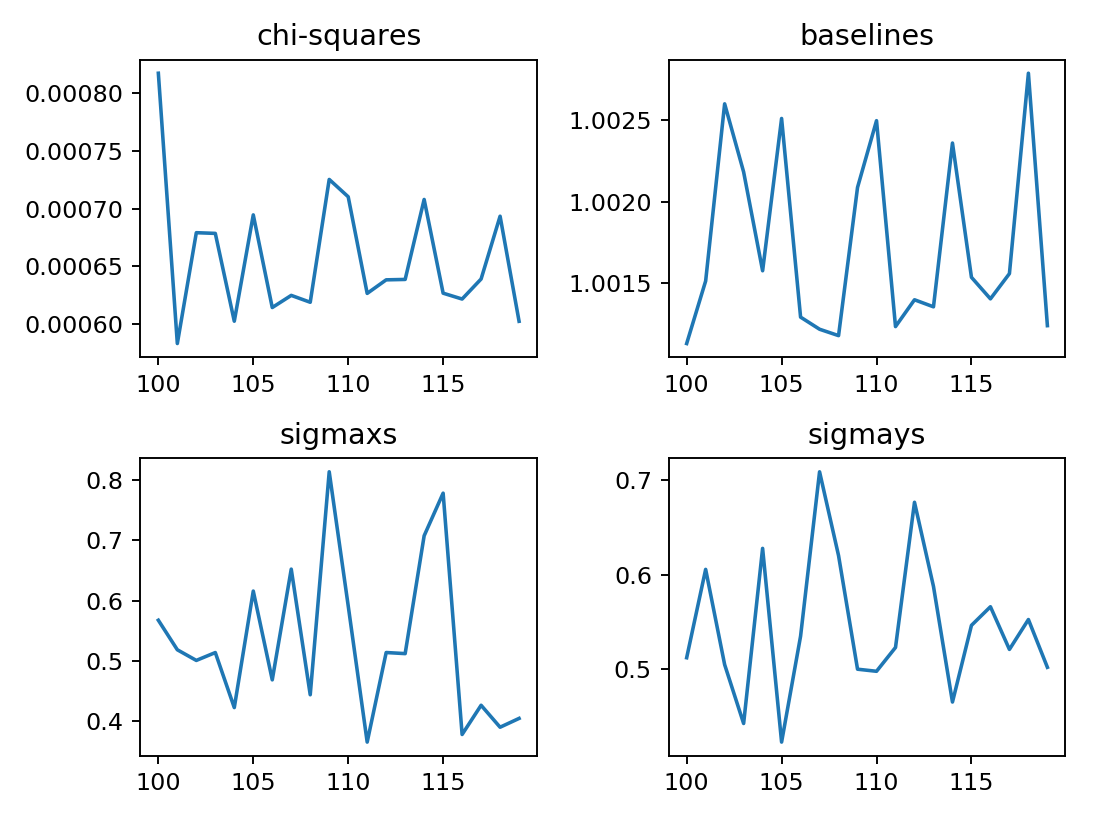

In [254]:
fig,axes=plt.subplots(2,2)
axes[0,0].plot(results[:,8],results[:,0])
axes[0,0].set_title("chi-squares")
axes[0,1].plot(results[:,8],results[:,1])
axes[0,1].set_title("baselines")
axes[1,0].plot(results[:,8],results[:,2])
axes[1,0].set_title("sigmaxs")
axes[1,1].plot(results[:,8],results[:,3])
axes[1,1].set_title("sigmays")
fig.tight_layout()

<IPython.core.display.Javascript object>


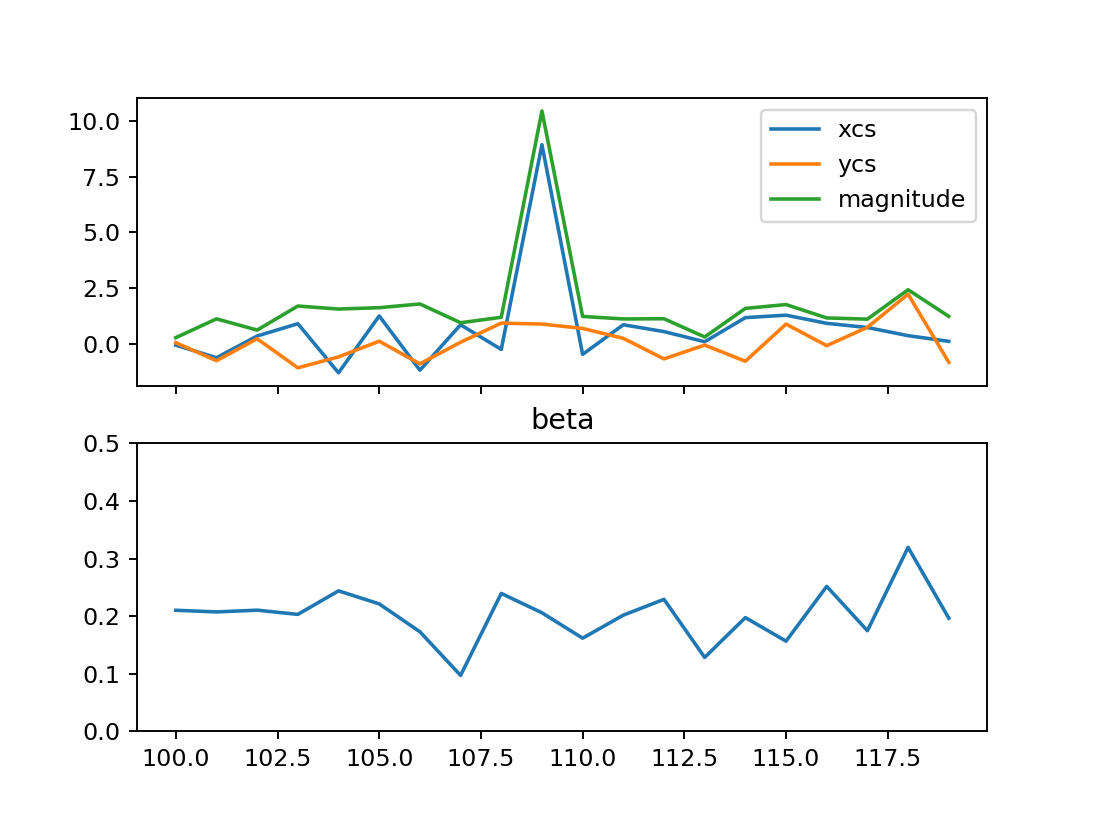

Text(0.5, 1.0, 'beta')

In [256]:
fig,ax=plt.subplots(2,sharex=True)
ax[0].plot(results[:,8],results[:,4],label="xcs")
ax[0].plot(results[:,8],results[:,5],label="ycs")
ax[0].plot(results[:,8],results[:,7],label="magnitude")
#ax[0].set_ylim(-1,1)
ax[0].legend()
#ax[0].set_title('uid=%s,scan_id=%d'%(uid,sid))
ax[1].plot(results[:,8],results[:,6])
ax[1].set_ylim(0,.5)
ax[1].set_title("beta")

<IPython.core.display.Javascript object>


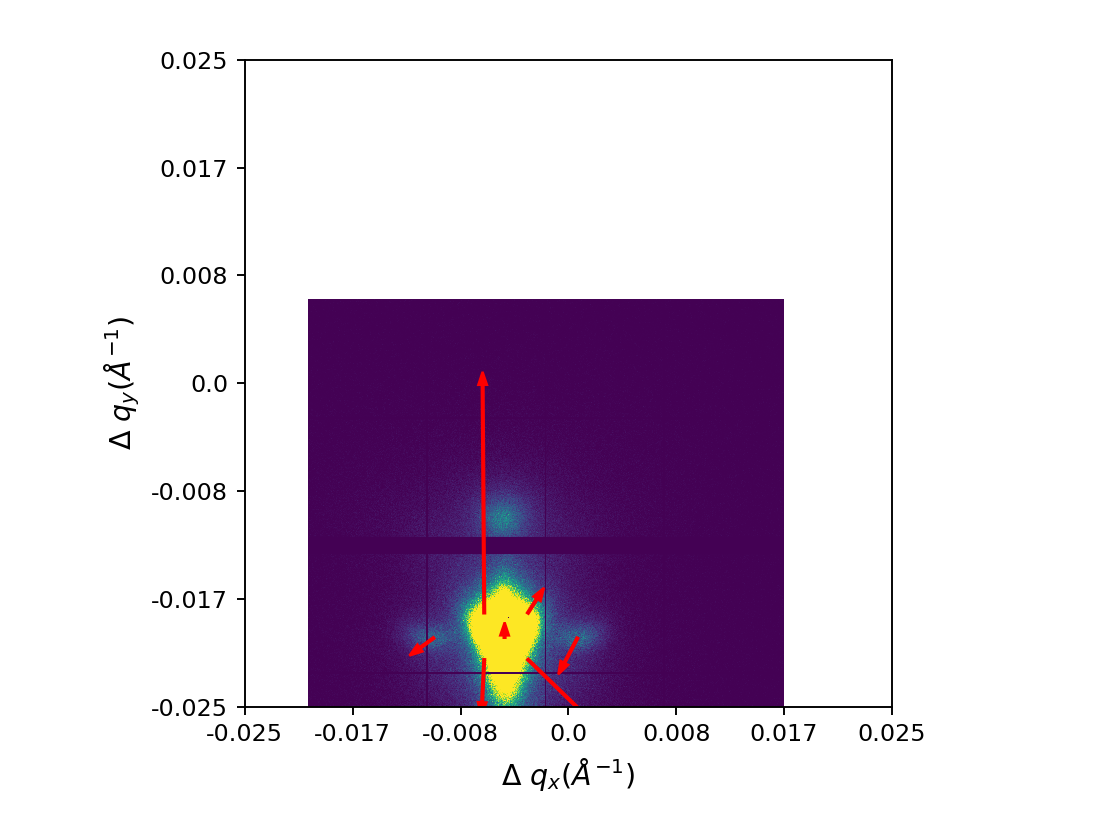

In [257]:
vecmags = np.hypot(xcs,ycs)
w = np.where(vecmags < 2)[0]
scl=150 *2.5
#from plot.plarrows import plarrows
fig,ax=plt.subplots()
#qextent = np.array([QX[0,0], QX[0,-1], QY[-1, 0], QY[0,0]])
wd= 700 #800
#qextent = np.array( [q_saxs[0], q_saxs[wd], q_saxs[0], q_saxs[wd] ])
ax.imshow(imgsa[0],vmin=0,vmax= np.average(imgsa[0]) * 5,
         extent=None,
         )

plarrows(qxs[w]+x0, qys[w]+y0, xcs[w]*scl, ycs[w]*scl, head_width=scl*.05, width=scl*.01,color='red');
#ax.set_title('uid=%s'%uid)
ax.set_title( ' ')
#xlim(-.03, .01);ylim(-.03, .01)

ax.set_xlim(  center[1] -wd, center[1] + wd    )
ax.set_ylim(  center[0] -wd, center[0] + wd    )


ytickp = np.linspace(   center[0] -wd, center[0] + wd , 7    )
ytick =  np.round( np.linspace(-0.0254, 0.02544, 7), 3)
tick = plt.yticks( ytickp, ytick )

xtickp = np.linspace(   center[1] -wd, center[1] + wd ,7    )
xtick =  np.round( np.linspace(-0.0254, 0.02544, 7), 3)
tick = plt.xticks( xtickp, xtick )

kfont =  1
ax.set_xlabel( r'$\Delta\ q_x (\AA^{-1})$', fontsize=12 * kfont )
ax.set_ylabel( r'$\Delta\ q_y (\AA^{-1})$', fontsize=12 * kfont )


fig.savefig( data_dir + 'uid=%s_speckle_shift.png'%uid)
#ax.plot(ycs,label="ycs")
fig.tight_layout()
